#  Logistic Regression and Classification Error Metrics

# Gustavo Gimpel Correia Lima
# Matrícula: 201512040488

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

# Os dados são lidos e analisados. Como a coluna de atividades é a única não numérica, as mesmas são codificadas para números inteiros de 0 a 5 utilizando o LabelEncoder, através da função fit_transform

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

5701     2
176      2
1321     2
4316     3
10250    4
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

# É calculada a correlação entre as características

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

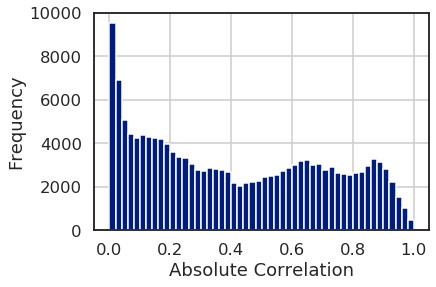

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

# Verificar as features que estão mais correlacionadas ajuda a identificar a necessidade de eventuais ajustes no dataset, como lidar com características similares ou redundantes.

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


# O StratifiedShuffleSplit é utilizado como alternativa ao KFold.
## 1) n_splits=1: consiste da quantidade de vezes que o dataset será embaralhado e particionado, para somente depois definir os grupos de teste e trieno.
## 2) test_size=0.3: proporção do número de amostras que serão utilizadas no treinamento. Empiricamente, algumas proporções de amostras de treino e de teste são ideais para a obtenção de bons modelos (Ex.: 70%-30%, 80%-20%, 75%-25%, respectivamente treino-teste)
## 3) random_state=42: um valor para iniciar o algoritmo de pseudo-aleatoriedade.

## Os conjuntos de treino e teste são construídos preservando a porcentagem de amostras de cada classe ao particionar o dataset.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=1000, n_jobs=16, penalty='none').fit(X_train, y_train)

# A LogisticRegressionCV é a regressão losgística utilizando validação cruzada (Cross-Validation)

# Regularização L1 (Lasso)
## 1) Cs=10: tanto para a regularização Ridge (L2) quanto para a regularização Lasso (L1) é utilizado um coeficiente λ denominado Fator de Regularização, que serve como uma espécie de peso para a expressão. No LogisticRegressionCV, o parâmetro Cs pode ser um número inteiro ou uma lista de floats, e o mesmo representa a inversa do fator de regularização.

## 2) cv=4: quando o parâmetro cv não é especificado, é utilizado por padrão o 5-fold. Como cv=4, é utilizado o 4-fold, ou seja, o dataset será subdividido em 4 partições ao realizar a validação cruzada

## 3) penalty='l1': Define qual será o método de regularização a ser utilizado. No caso desta, será a regularização L1 (Lasso).

## 4) solver='liblinear': De acordo com a documentação, os solvers ‘newton-cg’, ‘lbfgs’ and ‘sag’ conseguem utilizar apenas a regularização L2, enquanto ‘liblinear’ e ‘saga’ lidam com a regularização L1. Como trata-se da regularização L1, podem ser utilizados apenas os solvers 'liblinear' e 'saga'. E a própria documentação ainda afirma que a 'liblinear' é mais lenta que a 'saga', o que pôde ser verificado nesta prática.


In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(n_jobs=16, Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

# Regressão L2 (Ridge)

## 1) cv=4: serão realizadas 4 subpartições ao realizar a validação cruzada.

## 2) penalty='l2': Define qual será o método de regularização a ser utilizado. No caso desta, será a regularização L2 (Ridge)

## 3) Como não foi especificado o solver a ser utilizado, de acordo com a documentação o padrão a ser utilizado é o 'lbfgs'.

In [39]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(max_iter=1000, n_jobs=16, Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

## Comparando os coeficientes dos três modelos, é possível observar alguns pontos: 

## 1) A regressão utilizando a regularização L1 zerou alguns coeficientes, o que era esperando, pois os coeficiente menos importantes serão penalizados mais fortemente.

## 2) A regressão utilizando a regularização L2 penalizou todos os coeficientes, porém os coeficientes que eram maiores sem a regularização, foram mais penalizados.

## 3) Também é possível observar que, apesar da regularização L1 ter zerado alguns coeficientes, os que foram julgados como mais importantes não foram tão penalizados

In [19]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                              \
              0           1           2           3           4           5   
134   60.783705  233.098017 -152.151218 -132.916359 -113.853478  105.039332   
15   -47.856905 -106.184812  -46.127674   59.198599   63.902815   77.067977   
53   242.031802  170.416330 -257.355386  -15.817639   30.522679 -169.797786   
520  -86.824465  -34.735507 -118.832985   76.715351   99.990730   63.686876   
184 -150.287675  -56.870608 -234.071842  202.630685  -37.395021  275.994461   
148   32.661776  134.689830  -74.569679  149.651381  -99.229573 -143.203735   
255  -30.658843  -67.796981   48.281463   19.413280   60.302674  -29.541594   
66     2.325607   -7.159918  -94.390724 -107.879215  195.239059   11.865191   
40  -656.124576 -118.479365  464.044536  116.553413  131.022839   62.983152   
357  -10.762003  -65.066321   52.990167  -33.338399 -116.870372  173.046928   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
134  0.000000  0.000000  0.000000 -0.695831 -0.383513  2.858436  0.106367   
15   0.012886 -0.452491 -0.172200  0.000000 -0.412859 -0.743731  0.047580   
53   0.555676  2.365369 -6.671400  0.000000  0.904125 -1.735113  1.301332   
520 -0.021947  0.000000  0.000000  0.000000  0.630327 -0.620841 -0.114790   
184 -0.197122  2.173228 -0.874470  0.000000 -0.573138  1.491443 -0.316947   
148  0.396394  0.449153 -0.076806  0.397677 -1.265400 -3.642653  0.064681   
255  0.000000  0.000000  0.000000  0.000000  0.184662 -0.863133 -0.084447   
66   0.436816  0.000000  0.000000 -0.529044  0.972873  0.000000  0.001381   
40  -3.142125  6.057098  0.873815  0.000000  0.185431  0.000000 -2.782800   
357  0.120784  0.000000  0.731553  0.388537 -0.573008  1.269085 -0.089612   

                                                       
            1         2         3         4         5  
134  0.552738 -0.518720 -0.616281 -0.278813  0.754710  
15  -0.278710  0.047287 -0.074442  0.067959  0.190326  
53   1.632681 -2.892473  0.192214  0.410978 -0.644733  
520  0.027916 -0.229573  0.058527  0.220873  0.037047  
184  0.628360 -0.809081  0.490879 -0.723018  0.729807  
148  0.015772  0.129220  0.586658 -0.236306 -0.560024  
255 -0.270194  0.340016  0.041498  0.203850 -0.230723  
66  -0.039109 -0.285269 -0.392180  0.700120  0.015057  
40   0.384919  2.212101  0.163531  0.168365 -0.146117  
357 -0.304757  0.319463  0.000370 -0.493658  0.568195

Prepare six separate plots for each of the multi-class coefficients.

## Analisando os gráficos, é possível observar que sem a regularização, os coeficientes variam consideravelmente dentro da mesma escala. Ao aplicar a regularização L2, é visível que todos os coeficientes ficaram muito próximos a zero, enquanto na regularização L1, é possível observar alguns pequenos picos fora da linha dos coeficientes da regressão com regularização L2, o que significa que estes coeficientes específicos não foram tão severamente penalizados como na L2.

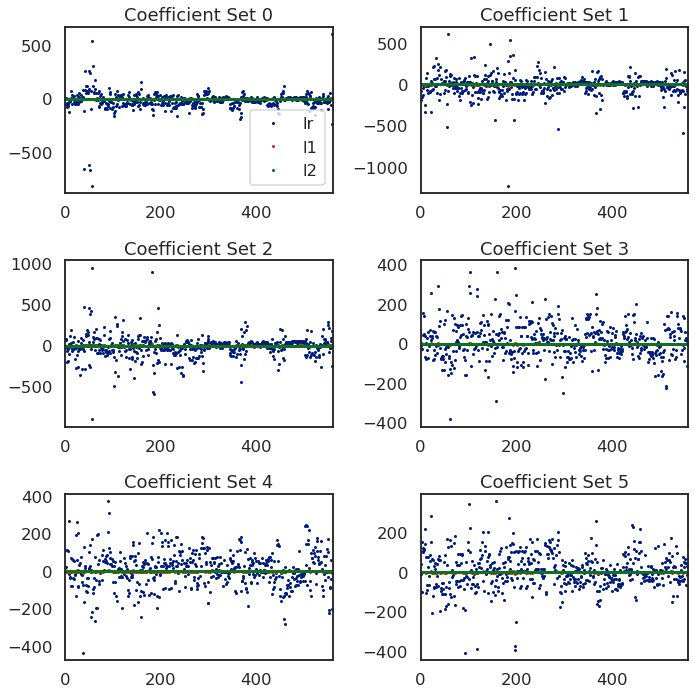

In [20]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

## Neste momento os modelos são utilizados para realizar as predições, e então os resultados são exibidos, permitindo uma comparação. As primeiras 5 amostras classificadas tiveram a mesma predição em todos os modelos, porém os dados não são suficientes para afirmar que a performance dos modelos é suficientemente boa.

In [21]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Na função abaixo, é possível verificar que a regressão sem regularização, para as 5 amostras exibidas, possui um grau de certeza maior em relação aos demais modelos. Para definir se um modelo como um todo é o melhor, antes é necessário avaliar as métricas de desempenho e as matrizes de confusão de cada um.

In [22]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998990,0.999999
1,1.0,0.999783,0.999908
2,1.0,0.996307,0.999557
3,1.0,0.999153,0.999327
4,1.0,0.999921,0.999784


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


## Analisando as métricas de desempenho dos modelos, é possível extrair algumas conclusões:

## 1) O melhor modelo foi com a regularização L2, visto que todas as métricas foram superiores a ambos os modelos com regularização L2 e sem regularização.

## 2) Apesar do modelo com regularização L2 ter sido superior, o modelo sem regularização e o modelo com regularização L1 também obtiveram bons desempenhos, apenas ligeiramente abaixo do L2.

In [24]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.982510,0.983505,0.985117
recall,0.982524,0.983495,0.985113
fscore,0.982512,0.983493,0.985113
accuracy,0.982524,0.983495,0.985113
auc,0.989397,0.989952,0.990950


## Question 8

Display or plot the confusion matrix for each model.

## Analisando as matrizes de confusão de cada modelo, é possível observar que o modelo com regularização L2 errou a menor quantidade de classificações.

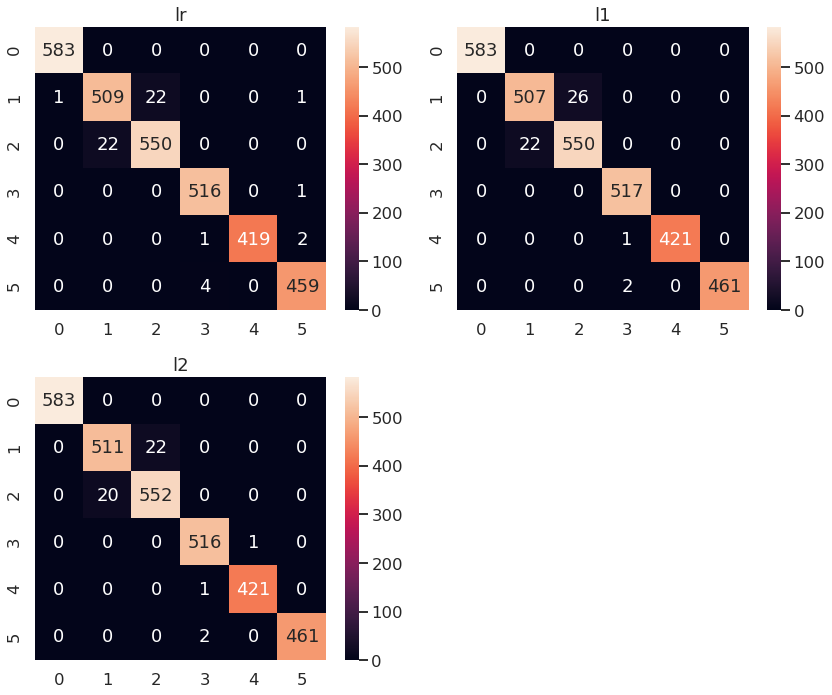

In [25]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

## Utilizando o VarianceThreshold para seleção de features, o resultado obtido foi indesejado, o modelo sem regularização teve um desempenho muito ruim (~0,18 de precision, recall e acurácia). Os modelos com regularização não conseguiram generalizar e tiveram um desempenho ainda pior, ignorando completamente algumas classes.

## Para tentar uma solução, foi utilizado o SelectKBest para a seleção de features, pois permite treinamento supervisionado. Não foi utilizado o chi2 como método de seleção pois o mesmo não permite números negativos. Desta forma, como não foi passado por parâmetro um método de seleção, o padrão utilizado é o 'f_classif', que por sua vez permite números negativos. A quantidade de features a serem selecionadas foi estabelecido em 400, valores muito baixos como 50-100 mantém as features mais importantes mas não são o suficiente para que o modelo consiga generalizar suficientemente.

## Contudo, mesmo utilizando o SelectKBest, apesar de melhorar as métricas de todos os modelos, o resultado ainda foi indesejado.

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_y = pd.concat([y_train,y_test])
#data_new = SelectKBest(k=400).fit_transform(data2, data_y)
data_new = pd.DataFrame(sel.fit_transform(data2))

from sklearn.model_selection import train_test_split

X_train_new, X_test_new = train_test_split(data_new)
Y_train_new, Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

## Modelos executados novamente, porém utilizando os novos datasets com as features selecionadas.

In [27]:
lr_new = LogisticRegression(max_iter=1000, n_jobs=16, penalty='none').fit(X_train_new, Y_train_new)

In [28]:
lr_l1_new = LogisticRegressionCV(n_jobs=16, Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_new, Y_train_new)

In [29]:
lr_l2_new = LogisticRegressionCV(n_jobs=16, Cs=10, cv=4, penalty='l2').fit(X_train_new, Y_train_new)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

## Utilizando o VarianceThreshold, foi possível observar que os coeficientes do modelo com regularização L1 ficaram todos zerados. Eventuais ajustes no threshold não surtiram efeito. Os coeficites do modelo com regularização L2 foram ajustados, porém não é possível tirar conclusões sem analisar as métricas de desempenho e as matrizes de confusão.

In [30]:
new_coefficients = list()

coeff_labels = ['lr_new', 'l1_new', 'l2_new']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    new_coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

new_coefficients = pd.concat(new_coefficients, axis=1)

new_coefficients.sample(10)

lr_new                                                      l1_new  \
            0         1         2         3         4         5         0   
186  0.049647  0.298497 -0.222503  0.866310 -0.650039 -0.341912  0.000000   
30  -0.179743 -0.196343  1.381572  0.063188  0.155912 -1.224586  0.000000   
252 -0.048240  0.022296  0.275734 -0.100662  0.183006 -0.332134  0.000000   
3   -0.077057 -0.048453 -0.877419  0.619850 -0.438100  0.821179  0.000000   
23   0.780131  0.145313 -0.358100 -0.348231 -0.045307 -0.173806  0.000000   
0   -0.735932  0.490237  0.077024  0.421121 -0.034284 -0.218166  0.000000   
18   0.039363 -0.621627 -0.015238  0.239670  1.141771 -0.783939  0.000000   
388 -0.322822 -0.425969  0.583022  0.433363 -0.312119  0.044525  0.000000   
335  0.069341 -0.194318  0.320508  0.149902 -0.509904  0.164472  0.000000   
171 -0.602559  0.730407 -0.625213  0.007520  1.514945 -1.025100 -0.030224   

                                    l2_new                                \
       1    2    3    4    5             0         1         2         3   
186  0.0  0.0  0.0  0.0  0.0 -1.994090e-04  0.000636  0.000085 -0.000060   
30   0.0  0.0  0.0  0.0  0.0 -1.400337e-04  0.000613  0.000034  0.000353   
252  0.0  0.0  0.0  0.0  0.0 -6.854121e-05  0.000391  0.000559 -0.000305   
3    0.0  0.0  0.0  0.0  0.0  9.821954e-07 -0.000284 -0.000754  0.000356   
23   0.0  0.0  0.0  0.0  0.0 -4.466609e-04 -0.000179  0.000406  0.000193   
0    0.0  0.0  0.0  0.0  0.0  1.906193e-05 -0.000265 -0.000731  0.000265   
18   0.0  0.0  0.0  0.0  0.0  2.894264e-04 -0.000745 -0.000644  0.000227   
388  0.0  0.0  0.0  0.0  0.0  4.336748e-04 -0.000060 -0.000392 -0.000405   
335  0.0  0.0  0.0  0.0  0.0  8.949876e-05  0.000226  0.000053 -0.000631   
171  0.0  0.0  0.0  0.0  0.0 -8.204806e-04 -0.000049 -0.000160 -0.000468   

                         
            4         5  
186 -0.000087 -0.000374  
30  -0.000204 -0.000656  
252  0.000045 -0.000621  
3    0.000276  0.000406  
23   0.001250 -0.001224  
0    0.000263  0.000448  
18   0.000941 -0.000068  
388  0.000309  0.000115  
335  0.000044  0.000219  
171  0.001477  0.000020

Prepare six separate plots for each of the multi-class coefficients.

## Utilizando o VarianceThreshold, é possível observar que a quantidade de features selecionadas foi muito pequena, o que pode explicar o motivo dos coeficientes de L1 terem sido zerados.

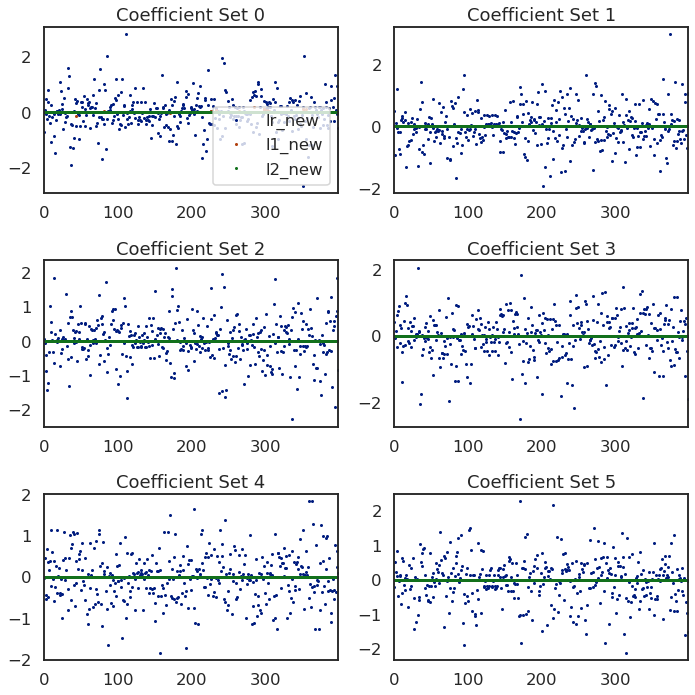

In [31]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = new_coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    ## Utilizando o VarianceThreshold, ambos os modelos com regularização L1 e L2 previram todas as amostras em questão como classe 0, enquanto a regressão sem regularização previu algumas como classe 2
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

## Utilizando o VarianceThreshold, é possível perceber que nas 5 amostras exibidas, os modelos variaram consideravelmente nas classificações que foram feitas. Contudo, como se tratam de apenas 5 amostras, não é possível tirar conclusões sobre a performance dos modelos com seleção de features.

In [32]:

y_pred = list()
y_prob = list()

coeff_labels = ['lr_new', 'l1_new', 'l2_new']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr_new,l1_new,l2_new
0,4,1,0
1,1,1,2
2,0,1,2
3,0,1,2
4,3,1,0


## Utilizando o VarianceThreshold, é possível observar que o grau de certeza de todos os modelos é consideravelmente baixo (~20%), porém como são apenas 5 amostras, não é possível concluir nada sobre os modelos.

In [33]:
y_prob.head()

,lr_new,l1_new,l2_new
0,0.290737,0.183789,0.193139
1,0.197400,0.185980,0.192202
2,0.251628,0.185411,0.191506
3,0.224043,0.185719,0.192074
4,0.221383,0.185672,0.190123


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [34]:
metrics_new = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(Y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(Y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(Y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(Y_test_new, y_pred[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics_new, axis=1)

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Analisando as métricas, já é possível concluir que os modelos obtidos possuem um desempenho muito ruim, principalmente se comparados com os mesmos modelos sem seleção de features.

In [35]:
metrics

,lr_new,l1_new,l2_new
precision,0.166955,0.032610,0.070719
recall,0.172427,0.180583,0.192621
fscore,0.165143,0.055244,0.103112
accuracy,0.172427,0.180583,0.192621
auc,0.499369,0.500000,0.506048


## Question 13

Display or plot the confusion matrix for each model.

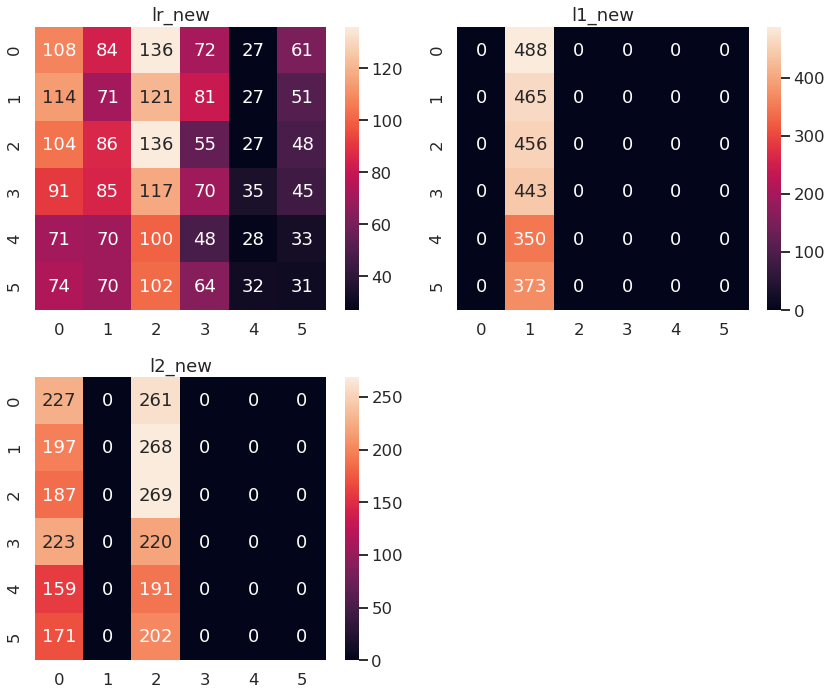

In [36]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

# As métricas de desempenho dos modelos sem seleção de features foi consideravelmente superior:

### precision:	0.982510	0.983505	0.985117   vs   0.166955	0.032610	0.070719
### recall:	        0.982524	0.983495	0.985113   vs   0.172427	0.180583	0.192621
### fscore:	       0.982512	   0.983493	   0.985113   vs   0.165143	0.055244	0.103112
### accuracy:	0.982524	0.983495	0.985113   vs   0.172427	0.180583	0.192621
### auc:	         0.989397	 0.989952	 0.990950   vs   0.499369	0.500000	0.506048


# As matrizes de confusão dos modelos com seleção de feature apontam que a quantidade de erros foi visivelmente superior. O modelo com regularização L1 classificou todas as amostras como uma mesma classe, enquanto a sem regularização foi extremamente aleatória, e a com regularização L2 alternou as classificações apenas entre duas classes, ilustrando as métricas baixas encontradas.